In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import qiskit
from qiskit import transpile
from qiskit.circuit import Parameter,ControlledGate
from qiskit_aer import Aer
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
np.random.seed = 42

NUM_QUBITS = 2
NUM_CIRCUITS = 3
NUM_SHOTS = 2000
SHIFT = 0.9
LEARNING_RATE = 0.01
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

Define function to translate Q-Circuit parameters from pytorch back to QISKIT

## 3. Contruct QuantumCircuit QFT Class

In [8]:
class QiskitCircuit():
    def __init__(self, n_qubits, backend, shots):
        self.beta = Parameter('Beta')
        self.gamma = Parameter('Gamma')
        self.shots = shots
        
        def create_circuit():
            ckt = QuantumCircuit(2, 2)
            ckt.rx(self.beta, 0)
            ckt.rx(self.beta, 1)

            ckt.cx(0,1)
            ckt.rz(-1*self.gamma, 1)
            ckt.cx(0,1)
            ckt.measure([0,1],[0,1])
            return ckt

        self.circuit = create_circuit()

    def energy_expectation(self, counts, shots, i,j, Cij=-1): #calculate expectation for one qubit pair
        expects = 0
        #print(counts)
        for key in counts.keys():
            perc = counts[key]/shots
            check = Cij*(float(key[i])-1/2)*(float(key[j])-1/2)*perc
            expects += check   
        return [expects] 

    def run(self, params):
        t_circuit = transpile(self.circuit, backend=self.backend)
        parameter_binds = [{self.thetas[k]: [params[k].item()] for k in range(NUM_QUBITS)}]
        job_sim = self.backend.run(t_circuit, shots=self.shots, parameter_binds=parameter_binds)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(t_circuit)
        return self.energy_expectation(counts, self.shots, 0, 1)

Expected value for rotation [pi/4]: [-0.1272]


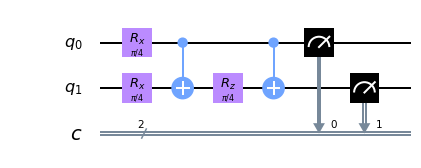

In [8]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl')

### TorchCircuit()

A pytorch layer always has two functions. One for the forward pass and one for the backward pass. The forward pass simply takes the Quantum Circuits variational parameters from the previous pytorch layer and runs the circuit on the defined hardware (defined in `QiskitCircuit.run()`) and returns the measurements from the quantum hardware.
These measurements will be the inputs of the next pytorch layer.

The backward pass returns the gradients of the quantum circuit. In this case here it is finite difference.

the `forward_tensor` is saved from the forward pass. So we just have to do one evaluation of the Q-Circuit in the backpass for the finite difference.

The `gradient` variable here is as well hard coded to 3 parameters. This should be updated in the future and made more general.

The loop `for k in range(len(input_numbers)):` goes through all the parameters (in this case 3), and shifts them by a small $\epsilon$. Then it runs the circuit and takes the diefferences of the ouput for the parameters $\Theta$ and $\Theta + \epsilon$. This is the finite difference. 

In [10]:
class TorchCircuit(Function):

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
        exp_value = ctx.QiskitCirc.run(i)
        result = torch.tensor([exp_value])
        ctx.save_for_backward(result, i)
        return result

    @staticmethod
    def backward(ctx, grad_output):

        forward_tensor, i = ctx.saved_tensors
        input_numbers = i
        gradients = torch.Tensor()
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients = torch.cat((gradients, gradient.float()))

        result = torch.Tensor(gradients)
        return (result.float() * grad_output.float()).T

In [11]:
x = torch.tensor([np.pi/4]*NUM_QUBITS, requires_grad=True)

qc = TorchCircuit.apply
y1 = qc(x)
print('y1 after quantum layer: {}'.format(y1))
y1 = nn.Linear(2**NUM_QUBITS,1)(y1.float())
y1.backward()
print('x.grad = {}'.format(x.grad))

y1 after quantum layer: tensor([[0.7520, 0.2480]], dtype=torch.float64, grad_fn=<TorchCircuitBackward>)
x.grad = tensor([-0.0002, -0.0014,  0.0010, -0.0048])


### Test the Quantum Circuit's Gradient Descent

First, we want the "neural net" consisting of just the quantum circuit (with its 4 inputs and 4 outputs) and a linear layer (from 4 inputs to 1 output) that scales measurement 1 by 1, measurement 2 by 2, etc., until it converges to a target value (-1). So, we define a cost function where the cost is defined as the square distance from the target value.

`x` is the initialization of the parameters. Here, every angle in the quantum circuit starts at $\pi/4$. We should see that the loss eventually goes down.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.25it/s]


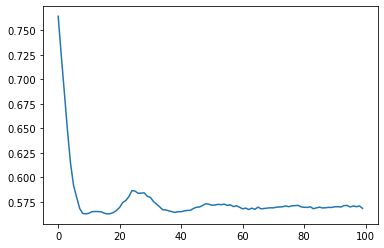

In [12]:
qc = TorchCircuit.apply
def cost(x):
    target = -1
    expval = qc(x)[0]
    val = sum([(i+1)*expval[i] for i in range(2**NUM_QUBITS)]) / 2**NUM_QUBITS
    return torch.abs(val - target) ** 2, expval
x = torch.tensor([-np.pi/4]*NUM_QUBITS, requires_grad=True)
opt = torch.optim.Adam([x], lr=0.1)

num_epoch = 75
loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval)

plt.plot(loss_list)

### MNIST in pytorch

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, transforms

### Load MNIST (0-9) Dataset

**Training Data**

In [14]:
n_samples = 150

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx = np.stack([np.where(X_train.targets == i)[0][:n_samples] for i in range(10)], axis=1)
idx = idx.reshape(-1)

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

**Testing Data**

In [15]:
n_samples = 150

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.stack([np.where(X_test.targets == i)[0][:n_samples] for i in range(10)])
idx = idx.reshape(-1)

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

### Define Neural Network with Q-node

This NN is  2 layers of ConvNN and a fully connected layer, with a Q-Node as a classifier.

In [16]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_QUBITS)
        self.qc = TorchCircuit.apply
        self.qcsim = nn.Linear(NUM_QUBITS, 1)
        self.fc3 = nn.Linear(1, 4)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = np.pi*torch.tanh(x)

        MODE = 'QC'
        if MODE == 'QC':
            x = qc(x[0])
        else:
            x = self.qcsim(x)
        x = torch.sigmoid(x)
        x = torch.cat((x, 1-x), -1)
        return x
    def predict(self, x):
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)

network = Network()#.to(device)
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [17]:
epochs = 20
loss_list = []
loss_func = nn.CrossEntropyLoss()

for epoch in tqdm(range(epochs)):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

Training [20%]	Loss: 0.6765


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

Training [40%]	Loss: 0.5759


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

Training [60%]	Loss: 0.4885


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

Training [80%]	Loss: 0.4249


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:37<00:00,  3.06it/s]

Training [100%]	Loss: 0.3781


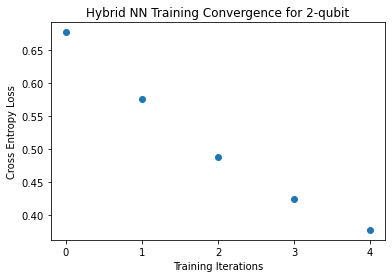

In [22]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')

### Test accuracy of NN

The outcome is not always the same because the prediction is probabilistic.

In [23]:
accuracy = 0
number = 0
for batch_idx, (data, target) in enumerate(test_loader):
    number +=1
    output = network.predict(data).item()
    accuracy += (output == target[0].item())*1

In [2]:
print("Performance on test data is : {}/{} = {}%".format(accuracy,number,100*accuracy/number))

Performance on test data is : 1035/1200 = 86.25%


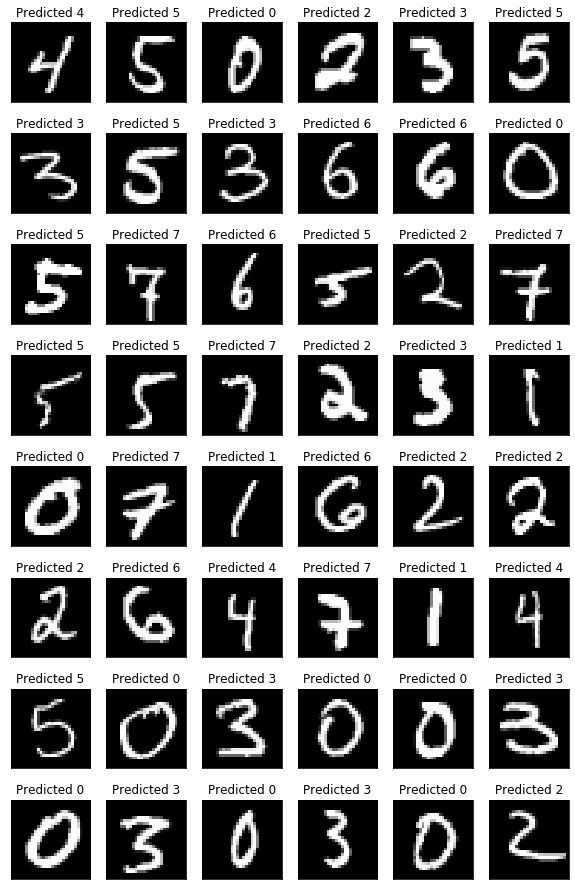

In [25]:
n_samples_shape = (8, 6)
count = 0
fig, axes = plt.subplots(nrows=n_samples_shape[0], ncols=n_samples_shape[1], figsize=(10, 2*n_samples_shape[0]))

network.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_shape[0]*n_samples_shape[1]:
            break
        pred = network.predict(data).item()

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_xticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_yticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_title('Predicted {}'.format(pred))
        
        count += 1

In [ ]:
z